In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 130912 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.3-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [2]:
 !ls

adc.json  sample_data


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [4]:
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda,Concatenate
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add
from keras.models import Model
from keras import regularizers
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.initializers import glorot_normal
#import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

Using TensorFlow backend.


In [0]:
import tensorflow as tf

In [0]:
def two_path(X_input):
  
  X = Conv2D(64,(7,7),strides=(1,1),padding='valid')(X_input)
  X = BatchNormalization()(X)
  X1 = Conv2D(64,(7,7),strides=(1,1),padding='valid')(X_input)
  X1 = BatchNormalization()(X1)
  X = layers.Maximum()([X,X1])
  X = Conv2D(64,(4,4),strides=(1,1),padding='valid',activation='relu')(X)
  
  X2 = Conv2D(160,(13,13),strides=(1,1),padding='valid')(X_input)
  X2 = BatchNormalization()(X2)
  X21 = Conv2D(160,(13,13),strides=(1,1),padding='valid')(X_input)
  X21 = BatchNormalization()(X21)
  X2 = layers.Maximum()([X2,X21])
  
  X3 = Conv2D(64,(3,3),strides=(1,1),padding='valid')(X)
  X3 = BatchNormalization()(X3)
  X31 =  Conv2D(64,(3,3),strides=(1,1),padding='valid')(X)
  X31 = BatchNormalization()(X31)
  X = layers.Maximum()([X3,X31])
  X = Conv2D(64,(2,2),strides=(1,1),padding='valid',activation='relu')(X)
  
  X = Concatenate()([X2,X])
  #X = Conv2D(5,(21,21),strides=(1,1))(X)
  #X = Activation('softmax')(X)
  
  #model = Model(inputs = X_input, outputs = X)
  return X

In [0]:
def input_cascade(input_shape1,input_shape2):
  
  X1_input = Input(input_shape1)
  X1 = two_path(X1_input)
  X1 = Conv2D(5,(21,21),strides=(1,1),padding='valid',activation='relu')(X1)
  X1 = BatchNormalization()(X1)
  
  X2_input = Input(input_shape2)
  X2_input1 = Concatenate()([X1,X2_input])
  #X2_input1 = Input(tensor = X2_input1)
  X2 = two_path(X2_input1)
  X2 = Conv2D(5,(21,21),strides=(1,1),padding='valid')(X2)
  X2 = BatchNormalization()(X2)
  X2 = Activation('softmax')(X2)
  
  model = Model(inputs=[X1_input,X2_input],outputs=X2)
  return model
  

In [0]:
def MFCcascade(input_shape1,input_shape2):
  
  X1_input = Input(input_shape1)
  X1 = two_path(X1_input)
  X1 = Conv2D(5,(21,21),strides=(1,1),padding='valid',activation='relu')(X1)
  X1 = BatchNormalization()(X1)
  #X1 = MaxPooling2D((2,2))(X1)
  
  X2_input = Input(input_shape2)
  X2 = two_path(X2_input)
  
  X2 = Concatenate()([X1,X2])
  X2 = Conv2D(5,(21,21),strides=(1,1),padding='valid',activation='relu')(X2)
  X2 = BatchNormalization()(X2)
  X2 = Activation('softmax')(X2)
  
  model = Model(inputs=[X1_input,X2_input],outputs=X2)
  return model
  

In [9]:
m = MFCcascade((53,53,4),(33,33,4))
m.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 53, 53, 4)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 47, 47, 64)   12608       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 47, 47, 64)   12608       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 47, 47, 64)   256         conv2d_1[0][0]                   
_____________________________________

In [0]:
m.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [0]:
m.save('trial_0001_MFCcascade_acc.h5')

In [12]:
m1 = input_cascade((65,65,4),(33,33,4))
m1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 65, 65, 4)    0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 59, 59, 64)   12608       input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 59, 59, 64)   12608       input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (None, 59, 59, 64)   256         conv2d_19[0][0]                  
__________________________________________________________________________________________________
batch_norm

In [0]:
import os
os.chdir('drive/Brain-Tumor-Segmentation-using-Deep-Neural-networks-master')

In [0]:
def model_gen(input_dim,x,y,slice_no):
  X1 = []
  X2 = []
  Y = []
  print(int((input_dim)/2))
  for i in range(int((input_dim)/2),175-int((input_dim)/2)):
    for j in range(int((input_dim)/2),195-int((input_dim)/2)):
      X2.append(x[i-16:i+17,j-16:j+17,:])
      X1.append(x[i-int((input_dim)/2):i+int((input_dim)/2)+1,j-int((input_dim)/2):j+int((input_dim)/2)+1,:])
      Y.append(y[i,slice_no,j])
      
  X1 = np.asarray(X1)
  X2 = np.asarray(X2)
  Y = np.asarray(Y)
  d = [X1,X2,Y]
  return d

In [0]:
def data_gen(path,slice_no,model_no):
  p = os.listdir(path)
  p.sort(key=str.lower)
  arr = []
  for i in range(len(p)):
    if(i != 4):
      p1 = os.listdir(path+'/'+p[i])
      p1.sort()
      img = sitk.ReadImage(path+'/'+p[i]+'/'+p1[-1])
      arr.append(sitk.GetArrayFromImage(img))
    else:
      p1 = os.listdir(path+'/'+p[i])
      img = sitk.ReadImage(path+'/'+p[i]+'/'+p1[0])
      y = sitk.GetArrayFromImage(img)    
  data = np.zeros((196,176,216,4))
  for i in range(196):
    data[i,:,:,0] = arr[0][:,i,:]
    data[i,:,:,1] = arr[1][:,i,:]
    data[i,:,:,2] = arr[2][:,i,:]
    data[i,:,:,3] = arr[3][:,i,:]
  x = data[slice_no]
  
  if(model_no == 0):
    X1 = []
    for i in range(16,159):
      for j in range(16,199):
        X1.append(x[i-16:i+17,j-16:j+17,:])
    Y1 = []
    for i in range(16,159):
      for j in range(16,199):
        Y1.append(y[i,slice_no,j]) 
    X1 = np.asarray(X1)
    Y1 = np.asarray(Y1)
    d = [X1,Y1]
  elif(model_no == 1):
    d = model_gen(65,x,y,slice_no)
  elif(model_no == 2):
    d = model_gen(56,x,y,slice_no)
  elif(model_no == 3):
    d = model_gen(53,x,y,slice_no)  
    
  return d   

In [23]:
d = data_gen('LG/0001',100,3)

26


In [24]:
d[2].all == 0

False

In [25]:
len(d[0])

17589

In [21]:
!pip3 install SimpleITK

     |████████████████████████████████| 42.5MB 1.4MB/s 


In [0]:
import SimpleITK as sitk
import numpy as np

In [0]:
y = np.zeros((17589,1,1,5))

In [0]:
for i in range(y.shape[0]):
  y[i,:,:,d[2][i]] = 1

In [28]:
sample = np.zeros((5,1))
for i in range(5):
  sample[i] = np.sum(y[:,:,:,i])
print(sample/np.sum(sample))  

[[9.62476548e-01]
 [2.06378987e-02]
 [4.20717494e-03]
 [1.21098414e-02]
 [5.68537154e-04]]


In [0]:
X1 = np.asarray(d[0])

In [30]:
X1.shape

(17589, 53, 53, 4)

In [0]:
X2 = np.asarray(d[1])

In [34]:
X2.shape

(17589, 33, 33, 4)

In [35]:
m1.inputs

[<tf.Tensor 'input_3:0' shape=(?, 65, 65, 4) dtype=float32>,
 <tf.Tensor 'input_4:0' shape=(?, 33, 33, 4) dtype=float32>]

In [0]:
m.compile(optimizer='adam',loss='categorical_crossentropy',metrics=[f1_score])

In [39]:
m_info = m.fit([X1,X2],y,epochs=20,batch_size=256)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/20
17589/17589 [==============================] - 58s 3ms/step - loss: 1.4447 - f1_score: nan
Epoch 2/20
17589/17589 [==============================] - 40s 2ms/step - loss: 1.3025 - f1_score: nan
Epoch 3/20
17589/17589 [==============================] - 40s 2ms/step - loss: 1.2001 - f1_score: nan
Epoch 4/20
17589/17589 [==============================] - 40s 2ms/step - loss: 1.1006 - f1_score: nan
Epoch 5/20
17589/17589 [==============================] - 40s 2ms/step - loss: 1.0117 - f1_score: 0.0549
Epoch 6/20
17589/17589 [==============================] - 40s 2ms/step - loss: 0.9306 - f1_score: 0.0552
Epoch 7/20
17589/17589 [==============================] - 40s 2ms/step - loss: 0.8566 - f1_score: 0.0571
Epoch 8/20
17589/17589 [==============================] - 40s 2ms/step - loss: 0.7855 - f1_score: 0.0591
Epoch 9/20
17589/17589 [======================

In [0]:
m.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

Slice 136 patient 0002

In [0]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(d[2]),
                                                 d[2])

In [43]:
class_weights

array([2.07797271e-01, 9.69090909e+00, 4.75378378e+01, 1.65154930e+01,
       3.51780000e+02])

In [54]:
import keras
model = keras.models.load_model('trial_0001_MFCcas_dim2_128_acc.h5')

OSError: ignored

In [45]:
m_info = m.fit([X1,X2],y,epochs= 20,batch_size = 256,class_weight = class_weights)

Epoch 1/20
17589/17589 [==============================] - 43s 2ms/step - loss: 0.2841 - acc: 0.9932
Epoch 2/20
17589/17589 [==============================] - 40s 2ms/step - loss: 0.2519 - acc: 0.9940
Epoch 3/20
17589/17589 [==============================] - 40s 2ms/step - loss: 0.2220 - acc: 0.9953
Epoch 4/20
17589/17589 [==============================] - 40s 2ms/step - loss: 0.2005 - acc: 0.9957
Epoch 5/20
17589/17589 [==============================] - 40s 2ms/step - loss: 0.1818 - acc: 0.9952
Epoch 6/20
17589/17589 [==============================] - 40s 2ms/step - loss: 0.1627 - acc: 0.9961
Epoch 7/20
17589/17589 [==============================] - 40s 2ms/step - loss: 0.1500 - acc: 0.9957
Epoch 8/20
17589/17589 [==============================] - 40s 2ms/step - loss: 0.1366 - acc: 0.9960
Epoch 9/20
17589/17589 [==============================] - 40s 2ms/step - loss: 0.1261 - acc: 0.9955
Epoch 10/20
17589/17589 [==============================] - 40s 2ms/step - loss: 0.1138 - acc: 0.9968

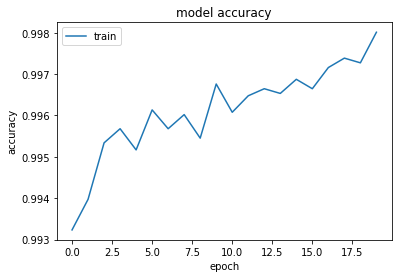

In [46]:
import matplotlib.pyplot as plt
plt.plot(m_info.history['acc'])
#plt.plot(m_info.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
m.save('trial_MFCcascade_acc.h5')

eval on 128th slice 0002

In [53]:
model.evaluate([X1,X2],y,batch_size = 1024)

NameError: ignored

In [0]:
model_info = model.fit([X1,X2],y,epochs=30,batch_size=256,class_weight= class_weights)

Epoch 1/30
17589/17589 [==============================] - 96s 5ms/step - loss: 0.1438 - acc: 0.9482
Epoch 2/30
17589/17589 [==============================] - 82s 5ms/step - loss: 0.0838 - acc: 0.9741
Epoch 3/30
17589/17589 [==============================] - 82s 5ms/step - loss: 0.0770 - acc: 0.9762
Epoch 4/30
17589/17589 [==============================] - 82s 5ms/step - loss: 0.0738 - acc: 0.9766
Epoch 5/30
16128/17589 [==========================>...] - ETA: 6s - loss: 0.0668 - acc: 0.979117589/17589 [==============================] - 82s 5ms/step - loss: 0.0669 - acc: 0.9794
Epoch 6/30
17589/17589 [==============================] - 82s 5ms/step - loss: 0.0646 - acc: 0.9800
Epoch 7/30
17589/17589 [==============================] - 82s 5ms/step - loss: 0.0625 - acc: 0.9810
Epoch 8/30
17589/17589 [==============================] - 82s 5ms/step - loss: 0.0599 - acc: 0.9817
Epoch 9/30
17589/17589 [==============================] - 82s 5ms/step - loss: 0.0548 - acc: 0.9837
Epoch 10/30
 2304

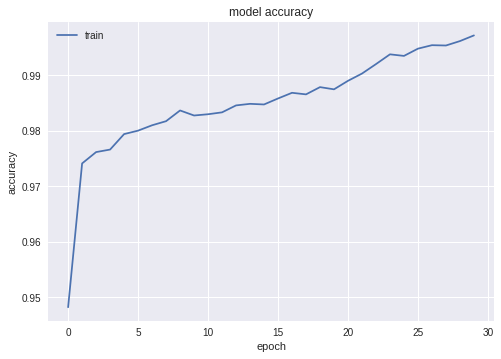

In [0]:
import matplotlib.pyplot as plt
plt.plot(model_info.history['acc'])
#plt.plot(m_info.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [52]:
model.save('trial_0001_MFCcas_dim2_128_acc.h5')

NameError: ignored

eval on 100th slice 0001

In [0]:
model.evaluate([X1,X2],y,batch_size = 1024)

17589/17589 [==============================] - 76s 4ms/step


[0.7340614805444402, 0.7623514699498087]

In [0]:
pred = model.predict([X1,X2],batch_size = 1024)
pred = np.around(pred)
pred1 = np.dot(pred.reshape(17589,5),np.array([0,1,2,3,4]))
y1 = np.dot(y.reshape(17589,5),np.array([0,1,2,3,4]))

In [0]:
y2 = np.argmax(y.reshape(17589,5),axis = 1)
y2.all() == 0

True

In [0]:
y1.all()==0

True

In [0]:
from sklearn import metrics

In [0]:
f1 = metrics.f1_score(y1,pred1,average='micro')
f1

0.7857183466939565

In [0]:
p1 = metrics.precision_score(y1,pred1,average='micro')
p1

0.7857183466939565

In [0]:
r1 = metrics.recall_score(y1,pred1,average='micro')
r1

0.7857183466939565

In [0]:
p2 = metrics.precision_score(y1,pred2,average='micro')
p2

0.9624765478424016

In [0]:
pred2 = np.zeros((17589))
f2 = metrics.f1_score(y1,pred2,average='micro')
f2

0.9624765478424016

Slice 128 patient 0001

In [0]:
from sklearn.utils import class_weight

In [0]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(d[2]),
                                                 d[2])

In [0]:
class_weights

array([2.09509401e-01, 8.01157025e+00, 3.93000000e+01, 1.36535211e+01,
       2.90820000e+02])

In [0]:
m1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [0]:
m1_info = m1.fit([X1,X2],y,epochs=20,batch_size=256,class_weight= class_weights)

Epoch 1/20
14541/14541 [==============================] - 127s 9ms/step - loss: 1.3402 - acc: 0.8345
Epoch 2/20
14541/14541 [==============================] - 123s 8ms/step - loss: 1.1816 - acc: 0.9560
Epoch 3/20
14541/14541 [==============================] - 123s 8ms/step - loss: 1.0906 - acc: 0.9647
Epoch 4/20
14541/14541 [==============================] - 123s 8ms/step - loss: 1.0021 - acc: 0.9735
Epoch 5/20
14541/14541 [==============================] - 123s 8ms/step - loss: 0.9231 - acc: 0.9801
Epoch 6/20
 5632/14541 [==========>...................] - ETA: 1:15 - loss: 0.8693 - acc: 0.982614541/14541 [==============================] - 123s 8ms/step - loss: 0.8494 - acc: 0.9830
Epoch 7/20
14541/14541 [==============================] - 123s 8ms/step - loss: 0.7881 - acc: 0.9829
Epoch 8/20
14541/14541 [==============================] - 123s 8ms/step - loss: 0.7332 - acc: 0.9854
Epoch 9/20
14541/14541 [==============================] - 123s 8ms/step - loss: 0.6731 - acc: 0.9879
Epoch 

plot of inputcascade

In [0]:
import matplotlib.pyplot as plt

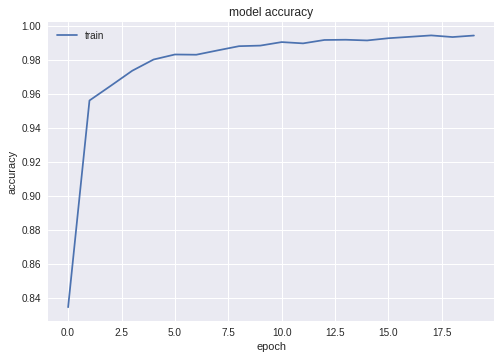

In [0]:
plt.plot(m1_info.history['acc'])
#plt.plot(m_info.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
m1.save('trial_0001_input_cascade_acc.h5')

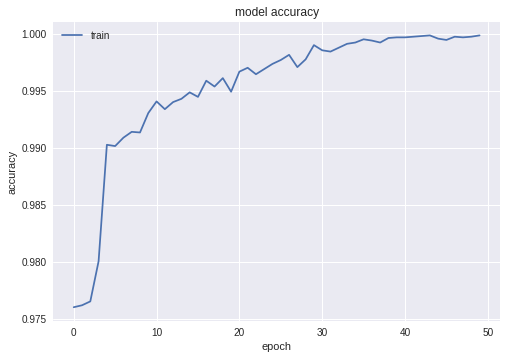

In [0]:
plt.plot(m_info.history['acc'])
#plt.plot(m_info.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Training on slice 128, evaluating on 136

In [0]:
m.evaluate([X1,X2],y,batch_size = 1024)

17589/17589 [==============================] - 74s 4ms/step


[0.14345772139377758, 0.9687304565353346]

In [0]:
m.save('trial_0001_MFCcas_dim2_128_acc.h5')

In [0]:
pred = m.predict([X1,X2],batch_size = 1024)

In [0]:
print(((pred != 0.) & (pred != 1.)).any())

False


In [0]:
pred = np.around(pred)

In [0]:
type(y)

numpy.ndarray

In [0]:
pred1 = np.dot(pred.reshape(17589,5),np.array([0,1,2,3,4]))

In [0]:
pred1.shape

(17589,)

In [0]:
y1 = np.dot(y.reshape(17589,5),np.array([0,1,2,3,4]))

In [0]:
from sklearn import metrics

In [0]:
f1 = metrics.f1_score(y1,pred1,average='micro')
f1

0.9703792142816533

In [0]:
pred2 = np.zeros((17589,1))
f1 = f1 = metrics.f1_score(y1,pred2,average='micro')
f1

0.9722553868895333

In [0]:
f1 = metrics.f1_score(y1,pred1,average='weighted')
f1

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.9635750235016781

In [0]:
f1 = metrics.f1_score(y1,pred1,average='macro')
f1

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.2460010612209343

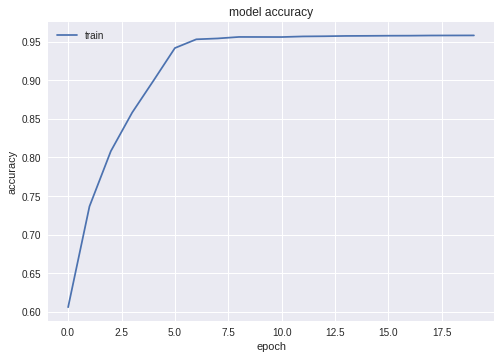

In [0]:
plt.plot(m_info.history['acc'])
#plt.plot(m_info.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
m_info = m.fit([X1,X2],y,epochs=20,batch_size=256,class_weight= 10*class_weights)

Epoch 1/20
17589/17589 [==============================] - 80s 5ms/step - loss: 0.3351 - acc: 0.9581
Epoch 2/20
17589/17589 [==============================] - 80s 5ms/step - loss: 0.3181 - acc: 0.9580
Epoch 3/20
17589/17589 [==============================] - 81s 5ms/step - loss: 0.3040 - acc: 0.9581
Epoch 4/20
17589/17589 [==============================] - 80s 5ms/step - loss: 0.2909 - acc: 0.9583
Epoch 5/20
16128/17589 [==========================>...] - ETA: 6s - loss: 0.2797 - acc: 0.958317589/17589 [==============================] - 80s 5ms/step - loss: 0.2796 - acc: 0.9583
Epoch 6/20
17589/17589 [==============================] - 80s 5ms/step - loss: 0.2695 - acc: 0.9578
Epoch 7/20
17589/17589 [==============================] - 80s 5ms/step - loss: 0.2597 - acc: 0.9581
Epoch 8/20
17589/17589 [==============================] - 80s 5ms/step - loss: 0.2476 - acc: 0.9582
Epoch 9/20
17589/17589 [==============================] - 80s 5ms/step - loss: 0.2342 - acc: 0.9613
Epoch 10/20
 2304

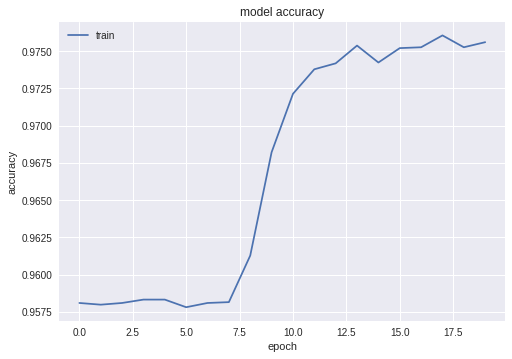

In [0]:
plt.plot(m_info.history['acc'])
#plt.plot(m_info.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
import matplotlib.pyplot as plt

In [0]:
m.save('trial_0001_MFCcas_dim2_128_acc.h5')

In [0]:
import keras

In [0]:
def two_pathcnn(input_shape):
  
  X_input = Input(input_shape)
  
  X = Conv2D(64,(7,7),strides=(1,1),padding='valid')(X_input)
  X = BatchNormalization()(X)
  X1 = Conv2D(64,(7,7),strides=(1,1),padding='valid')(X_input)
  X1 = BatchNormalization()(X1)
  X = layers.Maximum()([X,X1])
  X = Conv2D(64,(4,4),strides=(1,1),padding='valid',activation='relu')(X)
  
  X2 = Conv2D(160,(13,13),strides=(1,1),padding='valid')(X_input)
  X2 = BatchNormalization()(X2)
  X21 = Conv2D(160,(13,13),strides=(1,1),padding='valid')(X_input)
  X21 = BatchNormalization()(X21)
  X2 = layers.Maximum()([X2,X21])
  
  X3 = Conv2D(64,(3,3),strides=(1,1),padding='valid')(X)
  X3 = BatchNormalization()(X3)
  X31 =  Conv2D(64,(3,3),strides=(1,1),padding='valid')(X)
  X31 = BatchNormalization()(X31)
  X = layers.Maximum()([X3,X31])
  X = Conv2D(64,(2,2),strides=(1,1),padding='valid',activation='relu')(X)
  
  X = Concatenate()([X2,X])
  X = Conv2D(5,(21,21),strides=(1,1),padding='valid')(X)
  X = Activation('softmax')(X)
  
  model = Model(inputs = X_input, outputs = X)
  return model 

In [0]:
import os

In [0]:
m0 = two_pathcnn((33,33,4))
m0.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 33, 33, 4)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 27, 27, 64)   12608       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 27, 27, 64)   12608       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 27, 27, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_norm

In [0]:
os.chdir('drive/brat')

In [0]:
!ls

data.ipynb		model.ipynb
data_scan_0001.pickle	training.ipynb
data_trial_81.h5	trial_0001_81_accuracy.h5
data_trial_dim2_128.h5	trial_0001_81_f1.h5
data_trial.h5		trial_0001_accuracy.h5
data_trial_X.pickle	trial_0001_f1.h5
data_trial_Y.pickle	trial_0001_input_cascade_acc.h5
data_Y_0001.pickle	trial_0001_input_cascasde_acc.h5
HG			trial_0001_MFCcas_dim2_128_acc.h5
LG


for training over entire image, create batch of patches for one image, batch of labels in Y

In [0]:
import h5py
import numpy as np

In [0]:
hf = h5py.File('data_trial_dim2_128.h5', 'r')
X = hf.get('dataset_1')
Y = hf.get('dataset_2')

In [0]:
y = np.zeros((26169,1,1,5))

In [0]:
for i in range(y.shape[0]):
  y[i,:,:,Y[i]] = 1

In [0]:
X = np.asarray(X)

In [0]:
X.shape

(26169, 33, 33, 4)

In [0]:
keras.__version__

In [0]:
import keras.backend as K

def f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_true, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_pred, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

In [0]:
from sklearn.utils import class_weight

In [0]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(Y),
                                                 Y)

NameError: ignored

In [0]:
m0.compile(optimizer='adam',loss='categorical_hinge',metrics=[f1_score])

In [0]:
m0_info = m0.fit(X,y,epochs=20,batch_size=1024,class_weight = class_weights)

Epoch 1/20
26169/26169 [==============================] - 24s 901us/step - loss: 0.0967 - f1_score: 0.9517
Epoch 2/20
26169/26169 [==============================] - 23s 878us/step - loss: 0.0967 - f1_score: 0.9517
Epoch 3/20
26169/26169 [==============================] - 23s 881us/step - loss: 0.0967 - f1_score: 0.9517
Epoch 4/20
26169/26169 [==============================] - 23s 879us/step - loss: 0.0967 - f1_score: 0.9517
Epoch 5/20
26169/26169 [==============================] - 23s 878us/step - loss: 0.0967 - f1_score: 0.9517
Epoch 6/20
26169/26169 [==============================] - 23s 882us/step - loss: 0.0967 - f1_score: 0.9517
Epoch 7/20
26169/26169 [==============================] - 23s 881us/step - loss: 0.0967 - f1_score: 0.9517
Epoch 8/20
23552/26169 [=========================>....] - ETA: 2s - loss: 0.0959 - f1_score: 0.952126169/26169 [==============================] - 23s 879us/step - loss: 0.0967 - f1_score: 0.9517
Epoch 9/20
26169/26169 [==============================] 

In [0]:
m0.save('trial_0001_dim2_128_f1.h5')

In [0]:
!ls

data.ipynb		HG
data_scan_0001.pickle	LG
data_trial_81.h5	model.ipynb
data_trial_dim2_128.h5	trial_0001_81_accuracy.h5
data_trial.h5		trial_0001_81_f1.h5
data_trial_X.pickle	trial_0001_accuracy.h5
data_trial_Y.pickle	trial_0001_f1.h5
data_Y_0001.pickle	trial_0001_MFCcas_dim2_128_acc.h5


In [0]:
m0.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [0]:
m0_info = m0.fit(X,y,epochs=20,batch_size=4096,class_weight = class_weights)

Epoch 1/20
26169/26169 [==============================] - 41s 2ms/step - loss: 0.7791 - acc: 0.9517
Epoch 2/20
26169/26169 [==============================] - 25s 939us/step - loss: 0.7791 - acc: 0.9517
Epoch 3/20
26169/26169 [==============================] - 25s 939us/step - loss: 0.7791 - acc: 0.9517
Epoch 4/20
26169/26169 [==============================] - 25s 941us/step - loss: 0.7791 - acc: 0.9517
Epoch 5/20
26169/26169 [==============================] - 25s 941us/step - loss: 0.7791 - acc: 0.9517
Epoch 6/20
26169/26169 [==============================] - 25s 940us/step - loss: 0.7791 - acc: 0.9517
Epoch 7/20
26169/26169 [==============================] - 25s 941us/step - loss: 0.7791 - acc: 0.9517
Epoch 8/20
26169/26169 [==============================] - 25s 942us/step - loss: 0.7791 - acc: 0.9517
Epoch 9/20
26169/26169 [==============================] - 25s 940us/step - loss: 0.7791 - acc: 0.9517
Epoch 10/20
26169/26169 [==============================] - 25s 940us/step - loss: 0.

KeyboardInterrupt: ignored

In [0]:
m0.save('trial_0001_dim2_128_accuracy.h5')

In [0]:
!ls

In [0]:
mod = keras.models.load_model('trial_0001_81_accuracy.h5')

In [0]:
mod.evaluate(X,y,batch_size = 1024)

In [0]:
pred = m0.predict(X,batch_size = 1024)

In [0]:
pred.shape

(26169, 5)

In [0]:
pred = np.floor(pred)

In [0]:
y.reshape(26169,5)

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [0]:
pred.astype(int)

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

In [0]:
pred = pred.reshape(26169,5)
y_pred = np.floor(np.dot(pred,np.array([0,1,2,3,4])))
y_pred.reshape(26169,1)

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [0]:
y_pred.shape

(26169,)

In [0]:
print(((y_pred != 0.) & (y_pred != 1.)).any())

False


In [0]:
from matplotlib import pyplot as plt
plt.imshow(np.uint8(y_pred*32))
plt.show()

In [0]:
from sklearn import metrics

In [0]:
f1 = metrics.f1_score(y,pred)

In [0]:
!pip3 install SimpleITK

In [0]:
import SimpleITK as sitk
import numpy as np

In [0]:
path = 'LG/0001'
p = os.listdir(path)
p.sort(key=str.lower)
arr = []
for i in range(len(p)):
  if(i != 4):
    p1 = os.listdir(path+'/'+p[i])
    p1.sort()
    img = sitk.ReadImage(path+'/'+p[i]+'/'+p1[-1])
    arr.append(sitk.GetArrayFromImage(img))
  else:
    p1 = os.listdir(path+'/'+p[i])
    img = sitk.ReadImage(path+'/'+p[i]+'/'+p1[0])
    Y_labels = sitk.GetArrayFromImage(img)    
data = np.zeros((Y_labels.shape[1],Y_labels.shape[0],Y_labels.shape[2],4))
for i in range(196):
  data[i,:,:,0] = arr[0][:,i,:]
  data[i,:,:,1] = arr[1][:,i,:]
  data[i,:,:,2] = arr[2][:,i,:]
  data[i,:,:,3] = arr[3][:,i,:]
  

In [0]:
def model_gen(input_dim,x,y,slice_no):
  X1 = []
  X2 = []
  Y = []
  
  for i in range(int((input_dim)/2),175-int((input_dim)/2)):
    for j in range(int((input_dim)/2),195-int((input_dim)/2)):
      if(x[i-16:i+17,j-16:j+17,:].any != 0):
        X2.append(x[i-16:i+17,j-16:j+17,:])
        X1.append(x[i-int((input_dim)/2):i+int((input_dim)/2)+1,j-int((input_dim)/2):j+int((input_dim)/2)+1,:])
        Y.append(y[i,slice_no,j])
      
      
  X1 = np.asarray(X1)
  X2 = np.asarray(X2)
  Y = np.asarray(Y)
  d = [X1,X2,Y]
  return d

In [0]:
def data_gen(data,y,slice_no,model_no):
  d = []
  x = data[slice_no]
  if(x.any() != 0 and y.any() != 0):
    if(model_no == 0):
      X1 = []
      for i in range(16,159):
        for j in range(16,199):
          if(x[i-16:i+17,j-16:j+17,:].all != 0):
            X1.append(x[i-16:i+17,j-16:j+17,:])
      Y1 = []
      for i in range(16,159):
        for j in range(16,199):
          if(x[i-16:i+17,j-16:j+17,:].all != 0):
            Y1.append(y[i,slice_no,j]) 
      X1 = np.asarray(X1)
      Y1 = np.asarray(Y1)
      d = [X1,Y1]
    elif(model_no == 1):
      d = model_gen(65,x,y,slice_no)
    elif(model_no == 2):
      d = model_gen(56,x,y,slice_no)
    elif(model_no == 3):
      d = model_gen(53,x,y,slice_no)  
    
  return d   

In [0]:
from sklearn.utils import class_weight

In [0]:
m0.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [0]:
info = []
for i in range(90,data.shape[0],2):
  d = data_gen(data,Y_labels,i,0)
  if(len(d) != 0):
    y = np.zeros((d[-1].shape[0],1,1,5))
    for j in range(y.shape[0]):
      y[j,:,:,d[-1][j]] = 1
    X1 = d[0]
    class_weights = class_weight.compute_class_weight('balanced',
                                                      np.unique(d[-1]),
                                                      d[-1])
    print('slice no:'+str(i))
    info.append(m0.fit(X1,y,epochs=2,batch_size=32,class_weight= class_weights))
    m0.save('trial_0001_2path_acc.h5')

slice no:90
Epoch 1/2
24992/26169 [===========================>..] - ETA: 5s - loss: 1.1921e-07 - acc: 1.0000